# Opdracht Regressie


De bedoeling van regressie is om op basis van een getraind model voorspellingen te doen van continue waarden.
Concreet komt het er op neer dat er een verband gezocht wordt tussen één of meerdere features en een zekere output variabele y. Dit verband is een (multidimensionale) curve van de vorm $y = \theta_n x_n + ... \theta_1 x_1 + \theta_0$. De vector X is de set van features en de set van $\theta$'s noemen we de parameters.

De doelstellingen van deze opdracht zijn:
- Data kunnen inlezen en verwerken met de pandas library.
- Eenvoudige statistische analyses uitvoeren op de data met als doel het detecteren van de consistenties van de data en het kunnen inschatten van de samenhang tussen de verschillende features en de output variabele.  
- Correct kunnen opsplitsen van de data in een training set en test set.
- Weten hoe je data normaliseert.
- Trainen van een regressiemodel.
- Kunnen evalueren van het getrainde regressiemodel via verschillende metrics zoals MAE en de $R^2$-score.
- Feature engineering toepassen: manueel of automatisch extra (hogere orde features) toevoegen.
- Kunnen detecteren van overfitting en underfitting.
- L1 en L2 regularisatie toepassen om te regelen tussen overfitting en underfitting.

In [1]:
%matplotlib inline
import datetime
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML libraries inladen

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# Voor statistische data visualisatie
import seaborn as sns; sns.set(color_codes=True)
from scipy import stats

## 1. Wijnkwaliteit

Van heel wat (rode en witte) portugese Vinho Verde wijnen(http://www.vinhoverde.pt/en/) werden een aantal chemische parameters opgemeten. Ook werd aan een panel van wijnexperten gevraagd om de wijnen een kwaliteitsscore op smaak te geven tussen 0 en 10.

Een overzicht van de features: 1- fixed acidity | 2 - volatile acidity | 3 - citric acid | 4 - residual sugar | 5 - chlorides | 6 - free sulfur dioxide | 7 - total sulfur dioxide | 8 - density | 9 - pH | 10 - sulphates |11 - alcohol

De output of target variabele is 'quality', de kwaliteitsscore (score tussen 0 en 10).

De bedoeling is om via meervoudige regressie zo betrouwbaar mogelijk de kwaliteitsscore van een wijn te kunnen voorspellen op basis van de chemische parameters ervan.

In [2]:
# Dataset vanuit een csv bestand inlezen in een pandas dataframe.
dataset = pd.read_csv('winequality-red.csv',';')
dataset.shape

(1599, 12)

In [3]:
# Eerste rijen van de dataset
dataset.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Statistische vooranalyse

- Geef een samenvattende tabel met beschrijvende centrum- en spreidingswaarden via de describe funtie van pandas.
- Ga na of de dataset ontbrekende waarden bevat.
- Is er op het eerste zicht sprake van uitschieters? Niettegenstaande dit voor multidimensionele gecorreleerde data niet volledig opgaat mag je bij deze opdracht uitschieters aanzien als featurewaarden die meer dan 5 standaardafwijkingen rond het gemiddelde gelegen zijn.
- Maak een correlatie heatmap. Welke features lijken het meest invloed te hebben op de kwaliteitsscore? Zijn er features die onderling sterk gecorreleerd zijn. Als je 5 features zou willen weglaten, welke zouden dit zijn? Verklaar waarom. Bij deze vraag is de verklaring belangrijk.
- Maak een pairplot, bekijk deze aandachtig en formuleer enkele conclusies. Zijn er verbanden te leggen tussen wat je ziet op de pairplot en op de correlatie heatmap?

In [3]:
# Weglaten van de uitschieters:
# Normaal gezien alleen maar doen als je weet dat de uitschieters het gevolg zijn van 
# inconsistenties of fouten.
# Uitschieters uithalen met sigma (standaardafwijking)
dataset[(np.abs(stats.zscore(dataset)) < 5).all(axis=1)]
dataset.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


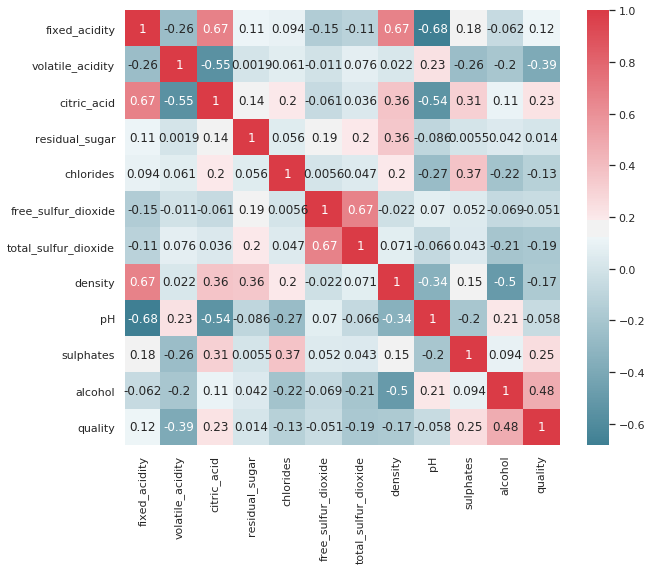

In [5]:
# Lineaire correlatie tussen de features - heatmap
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(dataset.corr(), annot=True, square=True, 
            mask=np.zeros_like(dataset.corr(), dtype=np.bool), ax=ax,
           cmap=sns.diverging_palette(220, 10, as_cmap=True))

# Zoeken naar een lineaire correlatie, alcohol beinvloed de score op een positieve manier terwijl
# volatile_acidity eerder een negatieve invloed heeft.
# Alcohol percentage heeft een grote invloed, maar het mag ook niet te veel worden
# oplossing -> kwadraat van alcohol erbij steken, dit gaat het uit levelen

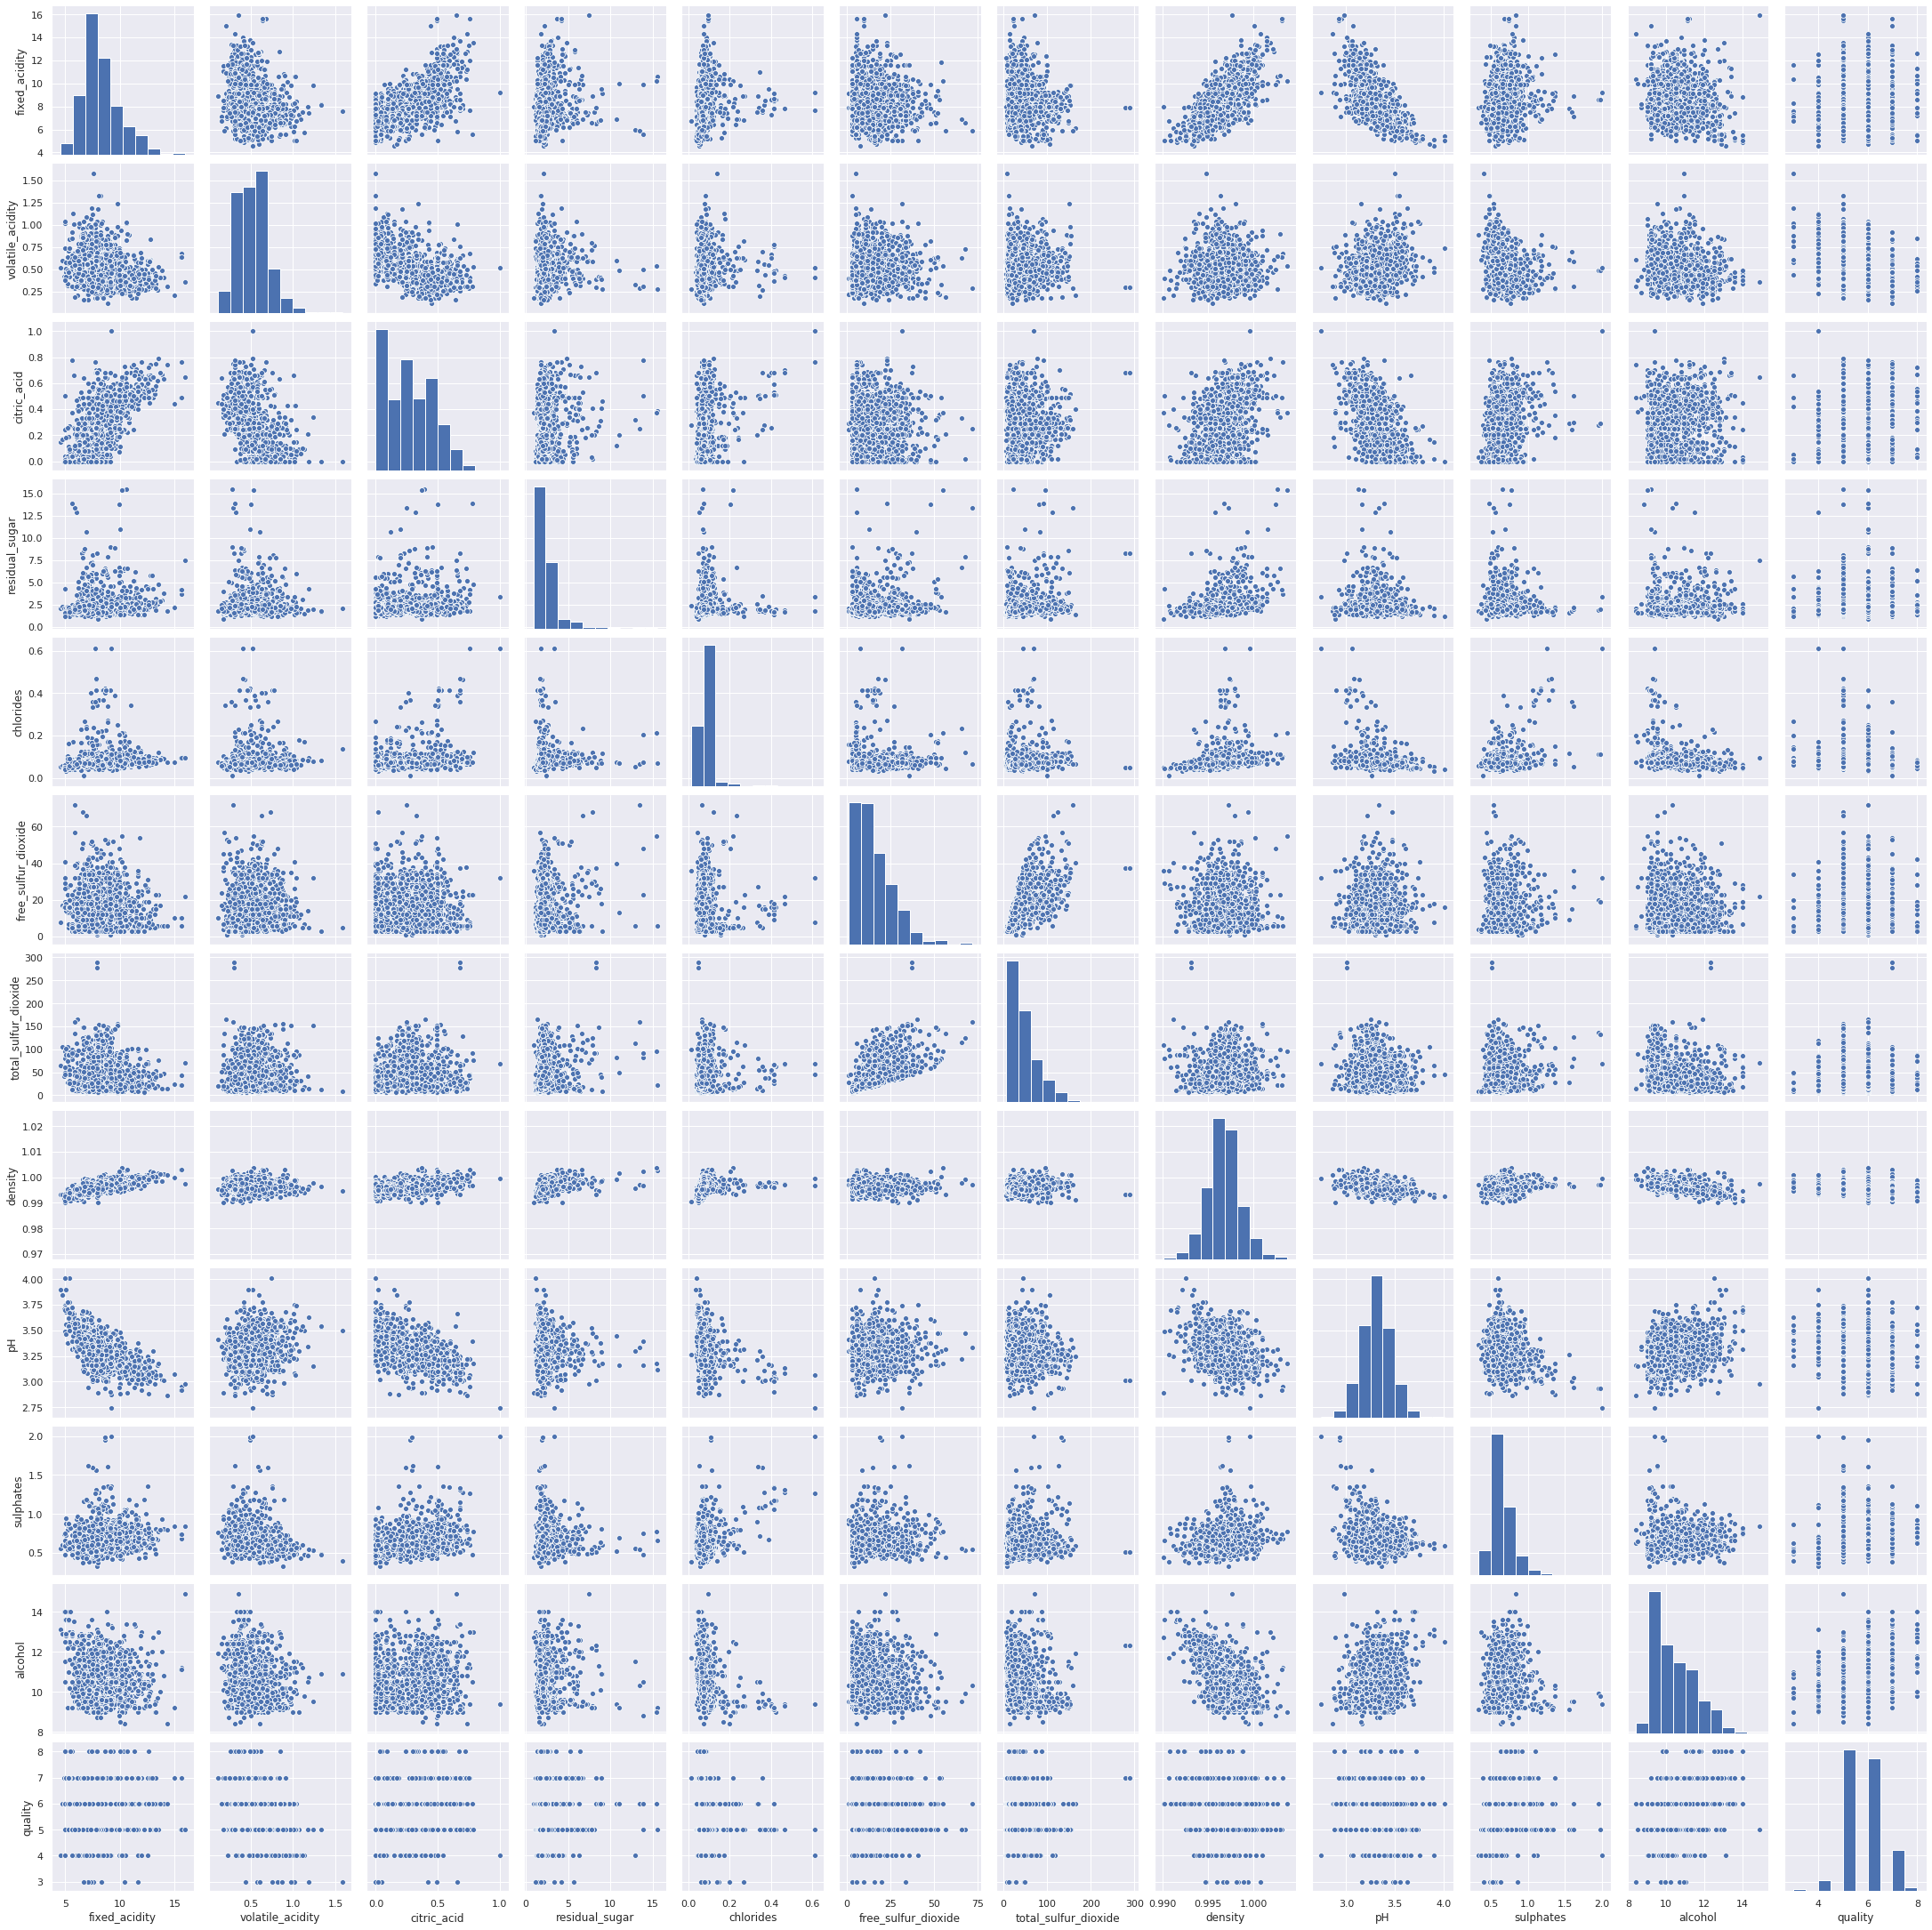

In [26]:
# Pairplot (=scatterplot). (Dit kan wat tijd vragen om te genereren)
# Formuleer conclusies
sns.pairplot(dataset)

### Conclusie

1. Het alcohols percentage heeft de sterkste invloed op de kwalitetit
2. Density heeft de meeste invloed op alle andere paramters

### Opsplitsen van de dataset

Splits de dataset op in features X en targets y. Vervolgens kan je de dataset opsplitsen in een training set en een test set. Gebruik hiervoor de functie train_test_split van Sklearn (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Zorg dat er 30 procent van de dataset in de test set terecht komt.

Normaliseer de training set en de test set met een standardscaler. Probeer later ook met een robustscaler.
Verklaar wat het verschil is tussen de standardscaler en de robustscaler.
De labels hoeven niet genormaliseerd te worden.

In [4]:
# Dataset opsplitsen in features en target
# features = list(dataset.columns[:dataset.columns.size - 1])
# x = dataset[features].values
# y = dataset['quality'].values
y = dataset['quality'].values
dataset.drop(['quality'], inplace=True, axis=1)
X = dataset.values

In [5]:
# Opsplitsen in training set en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [6]:
# Normaliseren van de training set en de test set
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Trainen van het regressiemodel

Train een regressiemodel via linear_model.LinearRegression(). Print vervolgens de coëfficiënten van het model. 

In [7]:
# Trainen van het regressiemodel
lin_reg = linear_model.LinearRegression()
modal = lin_reg.fit(X_train, y_train)

In [8]:
# print de coëfficiënten en de intercept van het model
print('tetas: ', modal.coef_)
print('intercept: ', modal.intercept_)

# coefs zijn gelijk aan de teta's (gewichten) die het model toekent aan de parameters
# intercept 

tetas:  [ 0.05072406 -0.21593633 -0.04954628  0.05182808 -0.06186489  0.0200203
 -0.10008073 -0.06398948 -0.05543456  0.15296722  0.27402123]
intercept:  5.647899910634488


### Testen en voorspellen
Voorspel de kwaliteitsscore van een wijn met chemische parameters:
									
fixed_acidity: 7.3 | 
volatile_acidity: 0.70 | citric_acid: 0.00 | residual_sugar: 1.9 | chlorides: 0.079 | free_sulfur_dioxide: 11.0 | total_sulfur_dioxide: 34.0 | density: 0.9978 | pH: 3.51 | sulphates: 0.58 | alcohol: 9.4

In [9]:
# Voorspelling van de kwaliteitsscore van de wijn.
test = np.array([[7.3, 0.70, 0, 1.9, 0.079, 11, 34, 0.9978, 3.51, 0.58, 9.4]])
test = scaler.fit_transform(test)
score = modal.predict(test)
print('Prediction: ', score)

Prediction:  [5.64789991]


Evalueer het regressiemodel op basis van de MAE, MSE en de $R^2$-score. Gebruik hiervoor de test set. Formuleer een aantal conclusies uit deze scores.

In [10]:
# Evaluatie van het model via de MAE, MSE en de R2-score

y_predicted = modal.predict(X_test)

print('MQE: ', mean_squared_error(y_test, y_predicted))

print('MAE: ', mean_absolute_error(y_test, y_predicted))

print('R2: ', r2_score(y_test, y_predicted))

# mean absolute error -> hoeveel de predictie afwijkt van de effectieve schore
# R2 score -> 

MQE:  0.4303223759466615
MAE:  0.49832050099638253
R2:  0.35120487764297725


### Scores
* DE MAE is gemiddeld 0.49. Dit wil zeggen dat de score gemiddeld met 0.49 afwijkt van de echte score.

### Modeloptimalisatie
Probeer de performantie van het model te verbeteren. Zorg er met andere woorden voor dat de MAE en de MSE verlaagd worden en de $R^2$ score toeneemt.
Mogelijke opties zijn:
- Toevoegen van hogere orde features (manueel). Motiveer waarom je bepaalde hogere orde features zou gebruiken. Kijk hiervoor bijvoorbeeld naar de pairplot of de correlatie heatmap (ga op zoek naar niet-lineariteiten).
- Extra features afleiden uit de bestaande features.
- Toepassen van regularisatie via Ridge regression en Lasso regression. Ga telkens op zoek naar een goede waarde voor alpha. 
- Ga telkens na of er overfitting over underfitting optreedt. Doe dit door de performantie op de training set te vergelijken met de performantie op de test set. 
- Voeg automatisch hogere orde features toe via sklearn.preprocessing.PolynomialFeatures. Ga niet hoger dan 3de of 4de orde. Het aantal features neemt namelijk exponentiëel toe met de orde met als gevolg dat het model niet meer binnen een aanneembare tijd te trainen valt.

Motiveer telkens de gemaakte keuze en evalueer het model met de test set. Wat is de beste performantie die je haalt? **Bespreek het eindresultataat**.

In [11]:
# Modeloptimalisatie en Hyperparameter tuning
# Regularisatie
# alpha varaiable -> hoe hard wordt het model afgestraft door onbelangerijke features
#                 -> hoe groter hoe simpeler (dommer)

from sklearn.preprocessing import PolynomialFeatures


# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)


# met L2 regularisatie via Ridge regression
lregmodel_poly = Ridge(alpha=70,tol=0.0001,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lregmodel_poly.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lregmodel_poly.score(X_train_poly,y_train))


# met L1 regularisatie via Lasso regression
lregmodel_poly = Lasso(alpha=0.01,tol=0.0001,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)      
  
      
print('R2 score op test set via L1: ',lregmodel_poly.score(X_test_poly,y_test))
  
# R2 -score via L1 op de trainingset
print('R2 score op training set via L1: ',lregmodel_poly.score(X_train_poly,y_train))    
  

R2 score op test set via L2:  0.355527441663394
R2 score op training set via L2:  0.4359128347046254
R2 score op test set via L1:  0.3659314962691399
R2 score op training set via L1:  0.4187928934451293


In [15]:
### Trainen en testen met gereduceerde features


## 2. Bierconsumptie

In het bestand *beerconsumption.csv* vind je een dataset met gegevens over de dagelijkse bierconsumptie in en een bepaalde stad (van het jaar 2015) in functie van de datum en de weersomstandigheden.
Bedoeling is om een regressiemodel te vinden dat een zo accuraat mogelijke voorspelling kan doen van de te verwachten bierconsumptie op een zekere dag met bepaalde te verwachten weersomstandigheden.

De verschillende features omvatten:
- date: datum
- average_temp: gemiddelde temperatuur van die dag in graden Celcius
- min_temp: minimum temperatuur van die dag in graden Celcius
- max_temp: maximum temperatuur van die dag in graden Celcius
- precipitation: de hoeveelheid neerslag in mm
- weekend: binaire variabele (0/1) die aanduidt of het al dan niet weekend is

De te voorspellen variabele (target) is 'consumption', de totale dagelijkse bierconsumptie in liter.


**Opdracht:**

- Controleer de dataset op inconsistenties: ontbrekende waarden, foutieve en extreme waarden
- Voeg twee kolommen toe aan de dataset. Noem deze kolommen 'month' en 'day'. In de ene kolom komt de naam van de maand (January, February, March, ...), in de andere de naam van de dag van de week (Monday, Tuesday, ...). Zoek online hoe je uit de datum de maandnaam en dagnaam kan halen. Verwijder vervolgens de 'date' kolom. Deze hebben we niet meer nodig.
- Vooranalyse: visualiseer de bierconsumptie per maand, bijvoorbeeld via boxplots (https://seaborn.pydata.org/generated/seaborn.boxplot.html). In welke maand wordt het meest bier geconsumeerd en in welke maand het minst? Visualiseer ook de bierconsumptie per dag. Op welke dagen van de week wordt het meest bier geconsumeerd en op welke dag het minst.

- Pas one-hot encoding toe op de features 'month' en 'day'. Zo worden categorische variabelen omgezet naar numerieke one-hot variabelen. Meer info over one-hot encoding is te vinden op https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b.

- Splits op in features en targets en maak vervolgens een training set en test set aan. Zorg ervoor dat er 100 samples in de test set zitten.

- Normaliseer de features. Categorische variabelen hoeven niet genormaliseerd te worden. Baseer je op de histogrammen om te beslissen welke normalisatie je zal toepassen (Standardscaler, MinMaxscaler of Robustscaler). De MinMaxscaler laat one-hot variabelen onveranderd.

- Train een regressiemodel

- Test het getraind model op de test set

- Doe optimalisaties en hyperparameter tuning om de performantie van het model (op de test set) te verhogen. Maak een grafiek van de r²-score in functie van de regularisatieparameter alpha.

- Bespreek het finaal bekomen model. Wat is de R²-score? Wat is de betekenis ervan? Wat zegt de bekomen MAE? Ga ook na welke twee features de grootste invloed hebben op de bierconsumptie.

- Zijn er features die je mag weglaten? Met andere woorden, zijn er overbodige features? Argumenteer.

- Voorspel de bierconsumptie op een zondag in juni bij een gemiddelde temperatuur van 28.64 graden, een min_temp van 25.22 en een max_temp van 31.08. Er is geen neerslag.



In [12]:
# Uitwerking opdracht bierconsumptie
dataset = pd.read_csv('beerconsumption.csv',',')
dataset.shape

(365, 7)

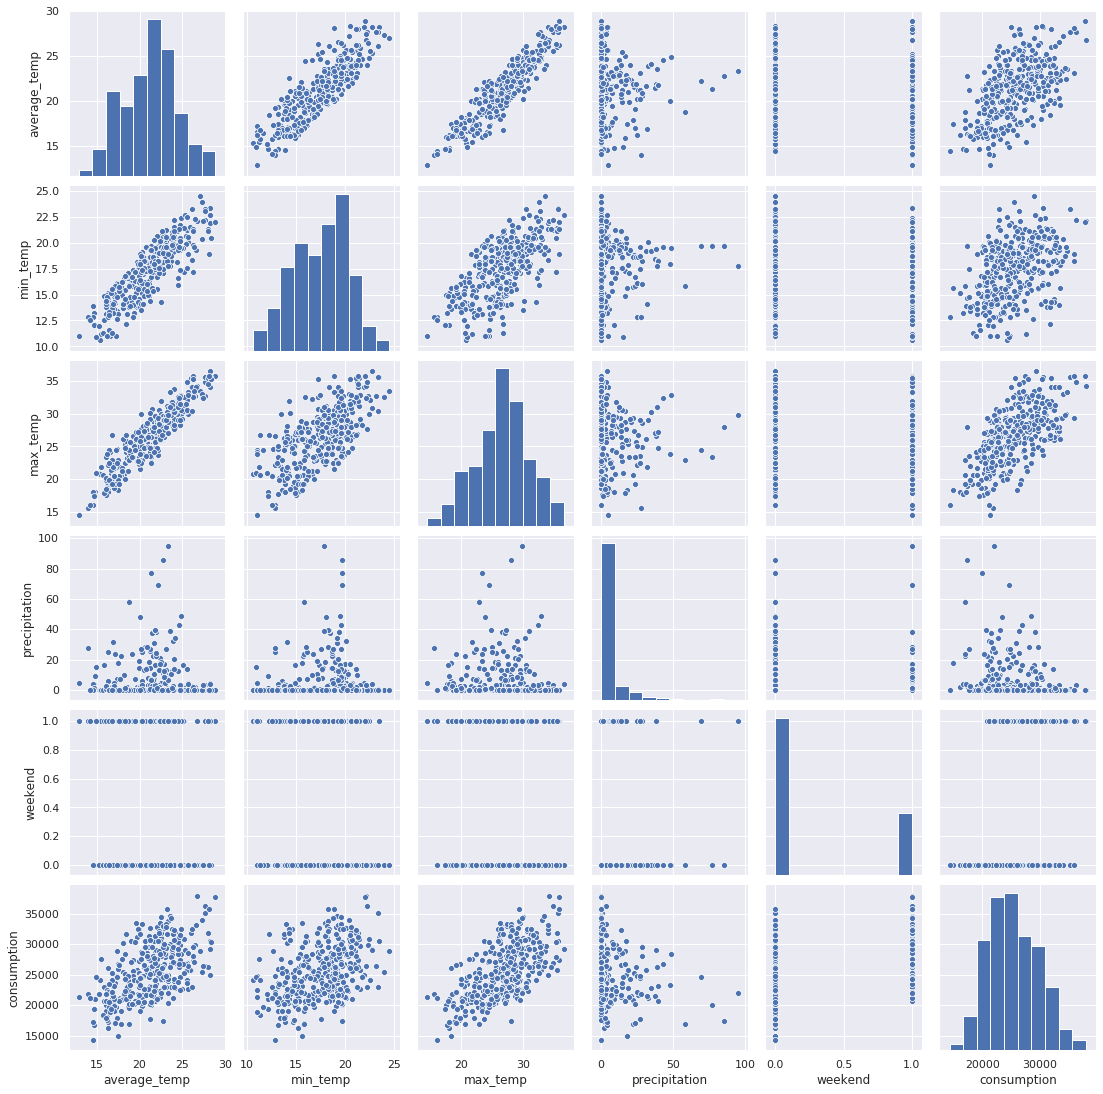

In [5]:
sns.pairplot(dataset)

In [13]:
dataset['month'] = pd.DatetimeIndex(dataset['date']).month_name()
dataset['day'] = pd.DatetimeIndex(dataset['date']).day_name()
dataset.drop(['date'], axis=1, inplace=True)
dataset.head()

,average_temp,min_temp,max_temp,precipitation,weekend,consumption,month,day
0,27.30,23.9,32.5,0.0,0,25461,January,Thursday
1,27.02,24.5,33.5,0.0,0,28972,January,Friday
2,24.82,22.4,29.9,0.0,1,30814,January,Saturday
3,23.98,21.5,28.6,1.2,1,29799,January,Sunday
4,23.82,21.0,28.3,0.0,0,28900,January,Monday


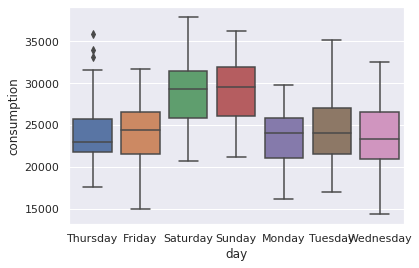

In [155]:
sns.boxplot(x=dataset['day'], y=dataset['consumption'])

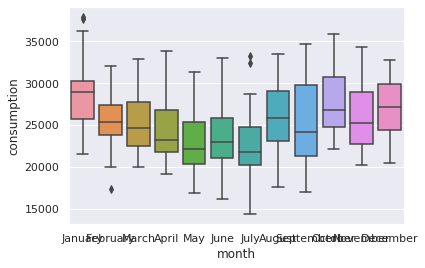

In [7]:
sns.boxplot(x=dataset['month'], y=dataset['consumption'])

### Vooranalyse
Zaterdag en zondag zijn de dagen waarop het meest gedronken wordt.
We zien ook dat er tijdens de feestmaanden Januari en December veel gedroneken wordt, alsook augustus en september.

In [14]:
dataset = pd.get_dummies(dataset, columns=['month', 'day'])
dataset.head()

,average_temp,min_temp,max_temp,precipitation,weekend,consumption,month_April,month_August,month_December,month_February,...,month_November,month_October,month_September,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,27.30,23.9,32.5,0.0,0,25461,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,27.02,24.5,33.5,0.0,0,28972,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,24.82,22.4,29.9,0.0,1,30814,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,23.98,21.5,28.6,1.2,1,29799,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,23.82,21.0,28.3,0.0,0,28900,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [15]:
y = dataset['consumption'].values
X = dataset.drop(['consumption'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100)

In [29]:
# from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
lin_reg = linear_model.LinearRegression()
model = lin_reg.fit(X_train, y_train)

In [34]:
y_predicted = model.predict(X_test)
MAE = mean_absolute_error(y_test,y_predicted)
print('MAE = ',MAE)
R2 = r2_score(y_test, y_predicted)
print('R2 = ', R2)

MAE =  2214.6381812972245
R2 =  0.5926053969790065


In [45]:

from sklearn.preprocessing import PolynomialFeatures


# Aanmaken van de hogere orde features
graad = 2

poly = PolynomialFeatures(graad)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)


# met L2 regularisatie via Ridge regression
lregmodel_poly = Ridge(alpha=13.27770829355429,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)

print('R2 score op test set via L2: ',lregmodel_poly.score(X_test_poly,y_test))
# R2 -score via L2 op de trainingset
print('R2 score op training set via L2: ',lregmodel_poly.score(X_train_poly,y_train))


# met L1 regularisatie via Lasso regression
lregmodel_poly = Lasso(alpha=60,fit_intercept=True)
lregmodel_poly.fit(X_train_poly,y_train)
      
print('R2 score op test set via L1: ',lregmodel_poly.score(X_test_poly,y_test))
  
# R2 -score via L1 op de trainingset
print('R2 score op training set via L1: ',lregmodel_poly.score(X_train_poly,y_train))    
  

R2 score op test set via L2:  0.4859713370179838
R2 score op training set via L2:  0.8722713850165449
R2 score op test set via L1:  0.5878507896579875
R2 score op training set via L1:  0.8263400914029287


Text(0, 0.5, 'R² Performance')

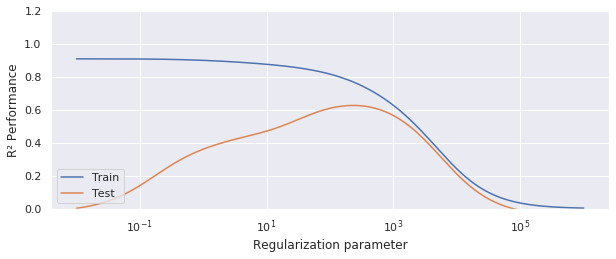

In [46]:

train_r2 = []
test_r2 = []


alphas = np.logspace(-2, 6, 1000)

for alpha in alphas:
    lregmodel_poly = Ridge(alpha=alpha,tol=0.0001,fit_intercept=True)
    lregmodel_poly.fit(X_train_poly,y_train)
    test_r2.append(lregmodel_poly.score(X_test_poly,y_test))  
    train_r2.append(lregmodel_poly.score(X_train_poly,y_train))


# Plot r2
f, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.semilogx(alphas, train_r2, label='Train')
plt.semilogx(alphas, test_r2, label='Test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization parameter')
plt.ylabel('R² Performance')

In [36]:
max_r2 = max(test_r2)
alphas[test_r2.index(max_r2)]

13.27770829355429

### Conclusie
Het normale lineare model presteert het best met een R2 score van 0.55 en een MEA van 2199 liter.  
**precipitation** lijkt niet meteen een invloed te hebben op het aantal liter geconsumeerde bier. Of eerder een negatieve invloed

In [48]:
test = [[28.26, 25.22,31.08, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
test = scaler.transform(test)
poly = PolynomialFeatures(graad)
poly.fit(test)
test_poly = poly.transform(test)

prediction = lregmodel_poly.predict(test_poly)
print('Consumptie: {0:.2f} liter'.format(prediction[0]))

Consumptie: 21546.99 liter
